# Analysis of Pokémon Dataset
**Goal:** Predict the **Combat Power (Total)** of a Pokémon based on its features.

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import os

sys.path.append(os.path.abspath(os.path.join('..')))

from src.regression_tree import RegressionTree
from src.random_forest import RandomForest
from src.utils import evaluate_model

# Set plot style
sns.set_theme(style="whitegrid")
%matplotlib inline

In [6]:
# Load the dataset
file_path = os.path.join('..', 'data', 'pokemon.csv')
df_raw = pd.read_csv(file_path)

print(f"Original Shape: {df_raw.shape}")
df_raw.head()

Original Shape: (151, 12)


,Name,Type 1,Type 2,Combat Power,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False
4,Charmeleon,Fire,NaN,405,58,64,58,80,65,80,1,False


## Preprocessing

In [7]:
def preprocess_pokemon(df):
    df = df.copy()
    
    # Drop non-predictive columns
    df = df.drop(columns=['#', 'Name'], errors='ignore')
    
    # Handle Missing Values
    if 'Type 2' in df.columns:
        df['Type 2'] = df['Type 2'].fillna('None')
    
    #Handle Categoricals
    cols_to_encode = ['Type 1', 'Type 2']
    existing_cols = [c for c in cols_to_encode if c in df.columns]
    
    df = pd.get_dummies(df, columns=existing_cols, drop_first=True, dtype=int)
    
    # Handle Booleans
    if 'Legendary' in df.columns:
        df['Legendary'] = df['Legendary'].astype(int)
        
    return df

# 4. Apply and Inspect
df_clean = preprocess_pokemon(df_raw)

print("Original Shape:", df_raw.shape)
print("Cleaned Shape: ", df_clean.shape)
print("\nFirst 5 rows of cleaned data:")
display(df_clean.head())

Original Shape: (151, 12)
Cleaned Shape:  (151, 34)

First 5 rows of cleaned data:


,Combat Power,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,Type 1_Dragon,...,Type 2_Flying,Type 2_Grass,Type 2_Ground,Type 2_Ice,Type 2_None,Type 2_Poison,Type 2_Psychic,Type 2_Rock,Type 2_Steel,Type 2_Water
0,318,45,49,49,65,65,45,1,0,0,...,0,0,0,0,0,1,0,0,0,0
1,405,60,62,63,80,80,60,1,0,0,...,0,0,0,0,0,1,0,0,0,0
2,525,80,82,83,100,100,80,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,309,39,52,43,60,50,65,1,0,0,...,0,0,0,0,1,0,0,0,0,0
4,405,58,64,58,80,65,80,1,0,0,...,0,0,0,0,1,0,0,0,0,0


## Data Split


In [8]:
target_col = 'Combat Power'

X = df_clean.drop(columns=[target_col]).values

y = df_clean[target_col].values

print(f"Feature Matrix X shape: {X.shape}")
print(f"Target Vector y shape:  {y.shape}")

Feature Matrix X shape: (151, 33)
Target Vector y shape:  (151,)


In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

print(f"Training Samples: {X_train.shape[0]}")
print(f"Test Samples:     {X_test.shape[0]} (Locked away)")

Training Samples: 120
Test Samples:     31 (Locked away)


## Training and Evaluation

--- REGRESSION TREE ---
  CV MSE (Error):    3051.3946
  CV R² (Stability):    0.6566
  Test MSE (Error):     2125.9586
  Test RMSE (Error):    46.1081
  Test R² (Accuracy):   0.8011
------------------------------
--- RANDOM FOREST ---
  CV MSE (Error):    1314.2538
  CV R² (Stability):    0.8602
  Test MSE (Error):     1320.6520
  Test RMSE (Error):    36.3408
  Test R² (Accuracy):   0.8765
------------------------------

--- Runtime summary ---
Training Random Forest Pokemon: 0.0001 s
Training Regression Tree Pokemon: 0.0000 s
Evaluation Regression Tree Pokemon: 0.1200 s
Evaluation Random Forest Pokemon: 2.4198 s


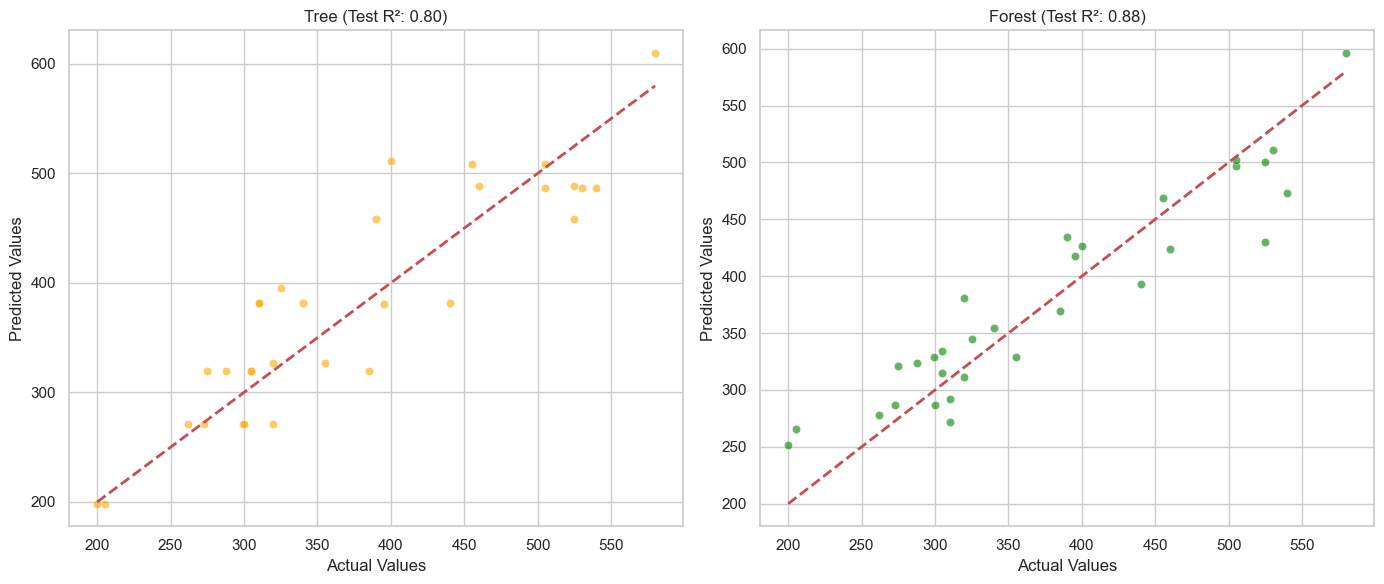

In [10]:
from re import M
from src.regression_tree import RegressionTree
from src.random_forest import RandomForest
from src.utils import evaluate_model, print_results, add_runtime, print_runtimes
import matplotlib.pyplot as plt
import seaborn as sns
import time


# 1. EVALUATE REGRESSION TREE
start_training_rt = time.time()
tree_model = RegressionTree(min_samples_split=10, max_depth=5)
duration_training_rt = time.time() - start_training_rt
add_runtime("Training Regression Tree Pokemon",duration_training_rt)

start_evaluation_rt = time.time()
tree_results = evaluate_model(tree_model, X_train, y_train, X_test, y_test)
duration_evaluation_rt = time.time() - start_evaluation_rt
add_runtime("Evaluation Regression Tree Pokemon",duration_evaluation_rt)

print_results("REGRESSION TREE", tree_results)

# 2. EVALUATE RANDOM FOREST

start_training_rf = time.time()
rf_model = RandomForest(n_trees=20, max_depth=float('inf'), min_samples_split=10, seed=123)
duration_training_rf = time.time() - start_training_rf
add_runtime("Training Random Forest Pokemon",duration_training_rf)

start_evaluation_rf = time.time()
rf_results = evaluate_model(rf_model, X_train, y_train, X_test, y_test)
duration_evaluation_rf = time.time() - start_evaluation_rf
add_runtime("Evaluation Random Forest Pokemon",duration_evaluation_rf)

print_results("RANDOM FOREST", rf_results)
print_runtimes()

# 3. VISUAL COMPARISON
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot Tree Results
sns.scatterplot(x=tree_results['y_test_actual'], y=tree_results['y_test_pred'], ax=axes[0], color='orange', alpha=0.6)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_title(f"Tree (Test R²: {tree_results['Test_R2']:.2f})")
axes[0].set_xlabel("Actual Values")
axes[0].set_ylabel("Predicted Values")

# Plot Forest Results
sns.scatterplot(x=rf_results['y_test_actual'], y=rf_results['y_test_pred'], ax=axes[1], color='green', alpha=0.6)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_title(f"Forest (Test R²: {rf_results['Test_R2']:.2f})")
axes[1].set_xlabel("Actual Values")
axes[1].set_ylabel("Predicted Values")

plt.tight_layout()
plt.show()

## Gridsearch

In [11]:
import itertools
from IPython.display import clear_output

# Define the Search Space
param_grid = {
    "n_trees": [10, 20, 50, 100],
    "max_depth": [5, 10, None],
    "min_samples_split": [5, 10]
}

# Generate  combinations
keys, values = zip(*param_grid.items())
combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

print(f"Starting Grid Search with {len(combinations)} candidates...")
print("-" * 60)

results_data = []
best_cv_r2 = -float("inf")
best_config = None

# Loop through every combination
for i, config in enumerate(combinations):
    clear_output(wait=True)

    print(f"[{i+1}/{len(combinations)}] Testing: {config}", end="")
    
    
    rf = RandomForest(
        n_trees=config["n_trees"], 
        max_depth=config["max_depth"] if config["max_depth"] is not None else float('inf'),
        min_samples_split=config["min_samples_split"],
        seed=123
    )
    
    # Run Evaluation
    metrics = evaluate_model(rf, X_train, y_train, X_test, y_test, n_splits=5)
    
    
    results_data.append({
        **config, 
        "CV_R2": metrics["CV_R2"],
        "Test_R2": metrics["Test_R2"],
        "Runtime": metrics["Runtime_Seconds"]
    })
    
    # Track the Winner
    if metrics["CV_R2"] > best_cv_r2:
        best_cv_r2 = metrics["CV_R2"]
        best_config = config


# Define tolerance
tolerance = 0.02 
threshold = best_cv_r2 - tolerance

# Display sorted table 
df_results = pd.DataFrame(results_data).sort_values(by="CV_R2", ascending=False)
display(df_results)

# Find models within tolerance
top_tier_models = df_results[df_results['CV_R2'] >= threshold].copy()

# Sort by runtime
efficient_winner = top_tier_models.sort_values(by='Runtime', ascending=True).iloc[0]

print("=" * 60)
print(f"ABSOLUTE ACCURACY WINNER (Best R²)")
print(f"   Config:  {df_results.iloc[0]['n_trees']} Trees, Depth {df_results.iloc[0]['max_depth']}")
print(f"   R²:      {df_results.iloc[0]['CV_R2']:.4f}")
print(f"   Runtime: {df_results.iloc[0]['Runtime']:.4f} s")
print("-" * 60)
print(f"EFFICIENT WINNER (Fastest model within {tolerance} of best score)")
print(f"   Config:  {efficient_winner['n_trees']} Trees, Depth {efficient_winner['max_depth']}")
print(f"   R²:      {efficient_winner['CV_R2']:.4f} (Diff: {efficient_winner['CV_R2'] - best_cv_r2:.4f})")
print(f"   Runtime: {efficient_winner['Runtime']:.4f} s")
print("=" * 60)



,n_trees,max_depth,min_samples_split,CV_R2,Test_R2,Runtime
16,50,NaN,5,0.874711,0.885759,8.417390
14,50,10.0,5,0.874389,0.885466,8.341719
22,100,NaN,5,0.869852,0.903661,16.512827
20,100,10.0,5,0.869756,0.903750,16.208586
17,50,NaN,10,0.868416,0.876590,6.318306
15,50,10.0,10,0.868394,0.876356,6.223337
8,20,10.0,5,0.867475,0.882715,3.265978
10,20,NaN,5,0.867381,0.882726,3.333238
23,100,NaN,10,0.862323,0.896336,12.386036
21,100,10.0,10,0.862192,0.896271,12.097580


ABSOLUTE ACCURACY WINNER (Best R²)
   Config:  50.0 Trees, Depth nan
   R²:      0.8747
   Runtime: 8.4174 s
------------------------------------------------------------
EFFICIENT WINNER (Fastest model within 0.02 of best score)
   Config:  20.0 Trees, Depth nan
   R²:      0.8602 (Diff: -0.0145)
   Runtime: 2.4538 s


## Comparison to Existing Implementations

We use the the default parameters for the existing techniques. Hence, the regression tree uses parameters `criterion='squared_error'` and `min_samples_split=2` and the random forest `criterion='squared_error'` and `n_estimators=100`.

The performance metrics for comparision are MSE/RMSE and $R^2$.

--- REGRESSION TREE existing ---
  CV MSE (Error):    3024.6740
  CV R² (Stability):    0.6627
  Test MSE (Error):     2276.1935
  Test RMSE (Error):    47.7095
  Test R² (Accuracy):   0.7871
------------------------------
--- RANDOM FOREST existing ---
  CV MSE (Error):    1087.6833
  CV R² (Stability):    0.8855
  Test MSE (Error):     1104.0956
  Test RMSE (Error):    33.2279
  Test R² (Accuracy):   0.8967
------------------------------

--- Runtime summary ---
Training Random Forest Pokemon: 0.0000 s
Training Regression Tree Pokemon: 0.0000 s
Evaluation Regression Tree Pokemon: 0.0056 s
Evaluation Random Forest Pokemon: 0.2624 s


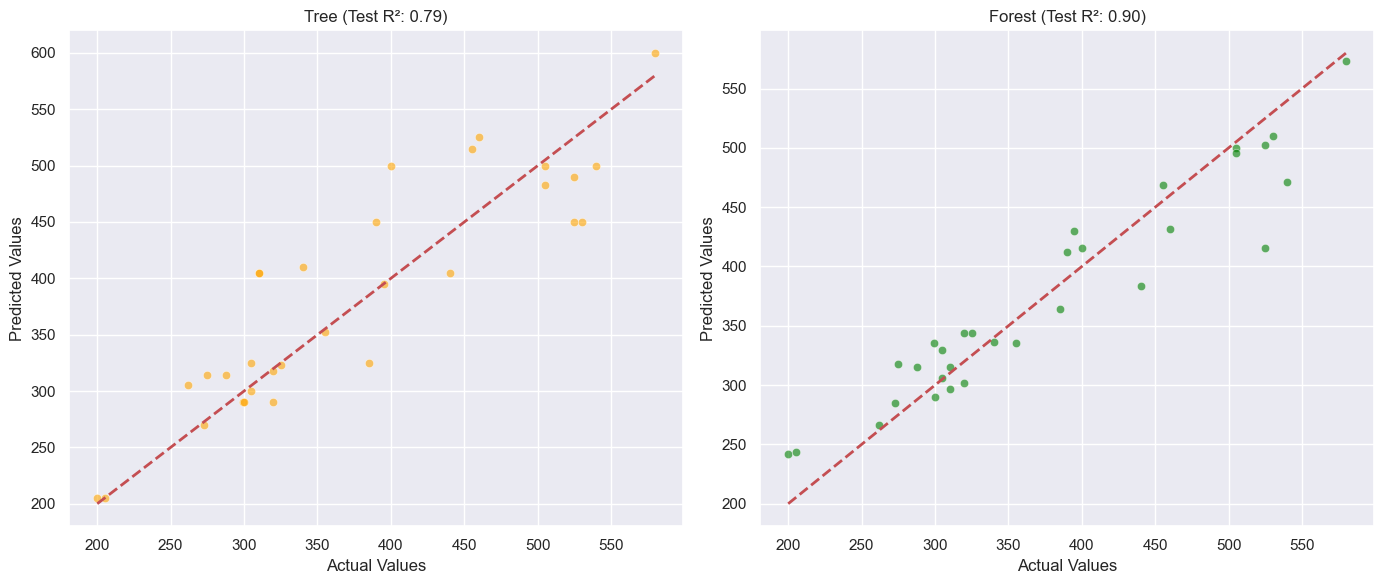

In [12]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import time
from src.utils import add_runtime, print_runtimes, evaluate_model
# EXISTING IMPLENTATIONS
# 1. EVALUATE REGRESSION TREE

start_training_rf = time.time()
tree_model_exist = DecisionTreeRegressor(random_state=123)
duration_training_rf = time.time() - start_training_rf
add_runtime("Training Random Forest Pokemon",duration_training_rf)

start_evaluation_rt = time.time()
tree_results_exist = evaluate_model(tree_model_exist, X_train, y_train, X_test, y_test)
duration_evaluation_rt = time.time() - start_evaluation_rt
add_runtime("Evaluation Regression Tree Pokemon",duration_evaluation_rt)

print_results("REGRESSION TREE existing", tree_results_exist)

# 2. EVALUATE RANDOM FOREST
# (Note: Using 'seed' as per your previous message)

start_training_rf = time.time()
rf_model_exist = RandomForestRegressor(random_state=123)
duration_training_rf = time.time() - start_training_rf
add_runtime("Training Random Forest Pokemon",duration_training_rf)

start_evaluation_rf = time.time()
rf_results_exist = evaluate_model(rf_model_exist, X_train, y_train, X_test, y_test)
duration_evaluation_rf = time.time() - start_evaluation_rf
add_runtime("Evaluation Random Forest Pokemon",duration_evaluation_rf)

print_results("RANDOM FOREST existing", rf_results_exist)
print_runtimes()

# 3. VISUAL COMPARISON
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot Tree Results
sns.scatterplot(x=tree_results_exist['y_test_actual'], y=tree_results_exist['y_test_pred'], ax=axes[0], color='orange', alpha=0.6)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_title(f"Tree (Test R²: {tree_results_exist['Test_R2']:.2f})")
axes[0].set_xlabel("Actual Values")
axes[0].set_ylabel("Predicted Values")

# Plot Forest Results
sns.scatterplot(x=rf_results_exist['y_test_actual'], y=rf_results_exist['y_test_pred'], ax=axes[1], color='green', alpha=0.6)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_title(f"Forest (Test R²: {rf_results_exist['Test_R2']:.2f})")
axes[1].set_xlabel("Actual Values")
axes[1].set_ylabel("Predicted Values")

plt.tight_layout()
plt.show()